In [1]:
import pandas as pd  
import matplotlib.pyplot as plt 
import numpy as np
from decimal import Decimal
from Utils import  *

CONSTANTS

In [2]:
DISTANCE_GALCHI_SUIRENITAR=30000
DISTANCE_BUDHI_SUIRENITAR=18500

MATPLLOTLIB SETTINGS

In [3]:
plt.style.use('ggplot')

Read CSV

In [4]:
galchi_df=pd.read_csv('Dataset/Galchi_2024-12-10 to 2024-12-12.csv')
budhi_df=pd.read_csv('Dataset/BudhiGandaki_2024-12-10 to 2024-12-12.csv')
suirenitar_df=pd.read_csv('Dataset/Siurenitar_2024-12-10 to 2024-12-12.csv')


In [5]:
def handle_null_values(df):
    #for the first null value with no preceeding value.
    df['value']=df['value'].fillna(method='bfill')
    #since water levels are continuous and expected to follow a natural trend we interpolate null values
    df['value']=df['value'].interpolate(method='linear') 

In [6]:
def handle_outliers(df):
    min_value=50
    max_value=10000000
    # Remove rows where the specific column's value is below the minimum or above the maximum threshold
    df = df[(df['value'] >= min_value) & (df['value'] <= max_value)].copy() 
    # print(df.head())
    
    return df

In [7]:
def preprocess_data(df):   
    df['dateTime']=pd.to_datetime(df['dateTime'])
    df['value']=pd.to_numeric(df['value'],errors='coerce')
    df.set_index('dateTime',inplace=True)
    df=handle_outliers(df)
    handle_null_values(df)
    return df


In [8]:
    #Only the original df should be preprocessed,else there will be error
galchi_df=preprocess_data(galchi_df)
budhi_df=preprocess_data(budhi_df)
suirenitar_df=preprocess_data(suirenitar_df)      

C:\Users\aryan\AppData\Local\Temp\ipykernel_11452\2824129155.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['value']=df['value'].fillna(method='bfill')
C:\Users\aryan\AppData\Local\Temp\ipykernel_11452\2824129155.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['value']=df['value'].fillna(method='bfill')
C:\Users\aryan\AppData\Local\Temp\ipykernel_11452\2824129155.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['value']=df['value'].fillna(method='bfill')


In [9]:
# print(suirenitar_df[suirenitar_df['value']<279.12])
suirenitar_df['value'].min()

np.float64(280.01651001)

In [10]:
galchi_df['discharge']=galchi_df.apply(lambda row:calculate_discharge_galchi(row['value']),axis=1)
budhi_df['discharge']=budhi_df.apply(lambda row:calculate_discharge_budhi(row['value']),axis=1)
suirenitar_df['discharge']=suirenitar_df.apply(lambda row:calculate_discharge_suirenitar(row['value']),axis=1)


In [11]:
galchi_df['mean_velocity']=galchi_df.apply(lambda row:calculate_mean_velocity_galchi(row['discharge']),axis=1)
budhi_df['mean_velocity']=budhi_df.apply(lambda row:calculate_mean_velocity_buddhi(row['discharge']),axis=1)

In [12]:
galchi_df[['time_lag_hr', 'time_lag_min']] = galchi_df.apply(
    lambda row: pd.Series(calcualte_time(DISTANCE_GALCHI_SUIRENITAR, row['mean_velocity'])), axis=1
)
budhi_df[['time_lag_hr', 'time_lag_min']] = budhi_df.apply(
    lambda row: pd.Series(calcualte_time(DISTANCE_BUDHI_SUIRENITAR, row['mean_velocity'])), axis=1
)


Shift df

In [13]:

def create_shifted_df(df):
    shifted_data = [
    {'dateTime': (index + pd.DateOffset(hours=lag_hr,minutes=lag_min)), 'discharge': discharge}
    for index, lag_hr,lag_min, discharge in zip(df.index, df['time_lag_hr'],df['time_lag_min'], df['discharge'])
]
    return pd.DataFrame(shifted_data)


In [14]:
shifted_galchi_df=create_shifted_df(galchi_df)
shifted_budhi_df=create_shifted_df(budhi_df)

In [15]:
shifted_budhi_df
shifted_budhi_df['dateTime'] = pd.to_datetime(shifted_budhi_df['dateTime'])
shifted_budhi_df.set_index('dateTime',inplace=True)

shifted_galchi_df
shifted_galchi_df['dateTime'] = pd.to_datetime(shifted_galchi_df['dateTime'])
shifted_galchi_df.set_index('dateTime',inplace=True)

In [ ]:

# Resample the data to a 5-minute frequency
shifted_budhi_df_resampled = shifted_budhi_df.resample('T').mean()

# Interpolate missing values
shifted_budhi_df_interpolated = shifted_budhi_df_resampled.interpolate(method='linear')


# Resample the data to a 5-minute frequency
shifted_galchi_df_resampled = shifted_galchi_df.resample('T').mean()

# Interpolate missing values
shifted_galchi_df_interpolated = shifted_galchi_df_resampled.interpolate(method='linear')

C:\Users\aryan\AppData\Local\Temp\ipykernel_11452\3654106487.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  shifted_budhi_df_resampled = shifted_budhi_df.resample('T').mean()
C:\Users\aryan\AppData\Local\Temp\ipykernel_11452\3654106487.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  shifted_galchi_df_resampled = shifted_galchi_df.resample('T').mean()


In [17]:
merged_df = pd.merge(
    shifted_galchi_df_interpolated, shifted_budhi_df_interpolated, 
    on='dateTime',      
    how='outer', 
    suffixes=('_galchi', '_budhi')
)

# Fill NaN with 0 and add the columns
merged_df['discharge'] = merged_df['discharge_galchi'].fillna(0) + merged_df['discharge_budhi'].fillna(0)


# Set 'discharge' to NaN if both columns are NaN
for index, row in merged_df.iterrows():
    if pd.isna(row['discharge_galchi']) and pd.isna(row['discharge_budhi']):
        merged_df.at[index, 'discharge'] = np.nan
        
        

In [18]:
merged_df

,discharge_galchi,discharge_budhi,discharge
dateTime,,,
2024-12-10 04:36:00,NaN,187.633287,187.633287
2024-12-10 04:37:00,NaN,178.284142,178.284142
2024-12-10 04:38:00,NaN,168.934998,168.934998
2024-12-10 04:39:00,NaN,171.737052,171.737052
2024-12-10 04:40:00,NaN,174.539106,174.539106
...,...,...,...
2024-12-13 06:09:00,88.840742,NaN,88.840742
2024-12-13 06:10:00,88.901690,NaN,88.901690
2024-12-13 06:11:00,88.962637,NaN,88.962637


In [19]:
computed_suirenitar_df=merged_df[['discharge']]
computed_suirenitar_df

,discharge
dateTime,
2024-12-10 04:36:00,187.633287
2024-12-10 04:37:00,178.284142
2024-12-10 04:38:00,168.934998
2024-12-10 04:39:00,171.737052
2024-12-10 04:40:00,174.539106
...,...
2024-12-13 06:09:00,88.840742
2024-12-13 06:10:00,88.901690
2024-12-13 06:11:00,88.962637


Visualize Computed Suirenitar

In [20]:
# fig,ax=plt.subplots(figsize=(20,10),sharex=True)
# computed_suirenitar_df.plot(color='green',ax=ax,label='computed')
# suirenitar_df['discharge'].plot(color='red',ax=ax,label='actual')
# plt.legend(['computed','actual'])
# plt.show()

Visualize Peaks

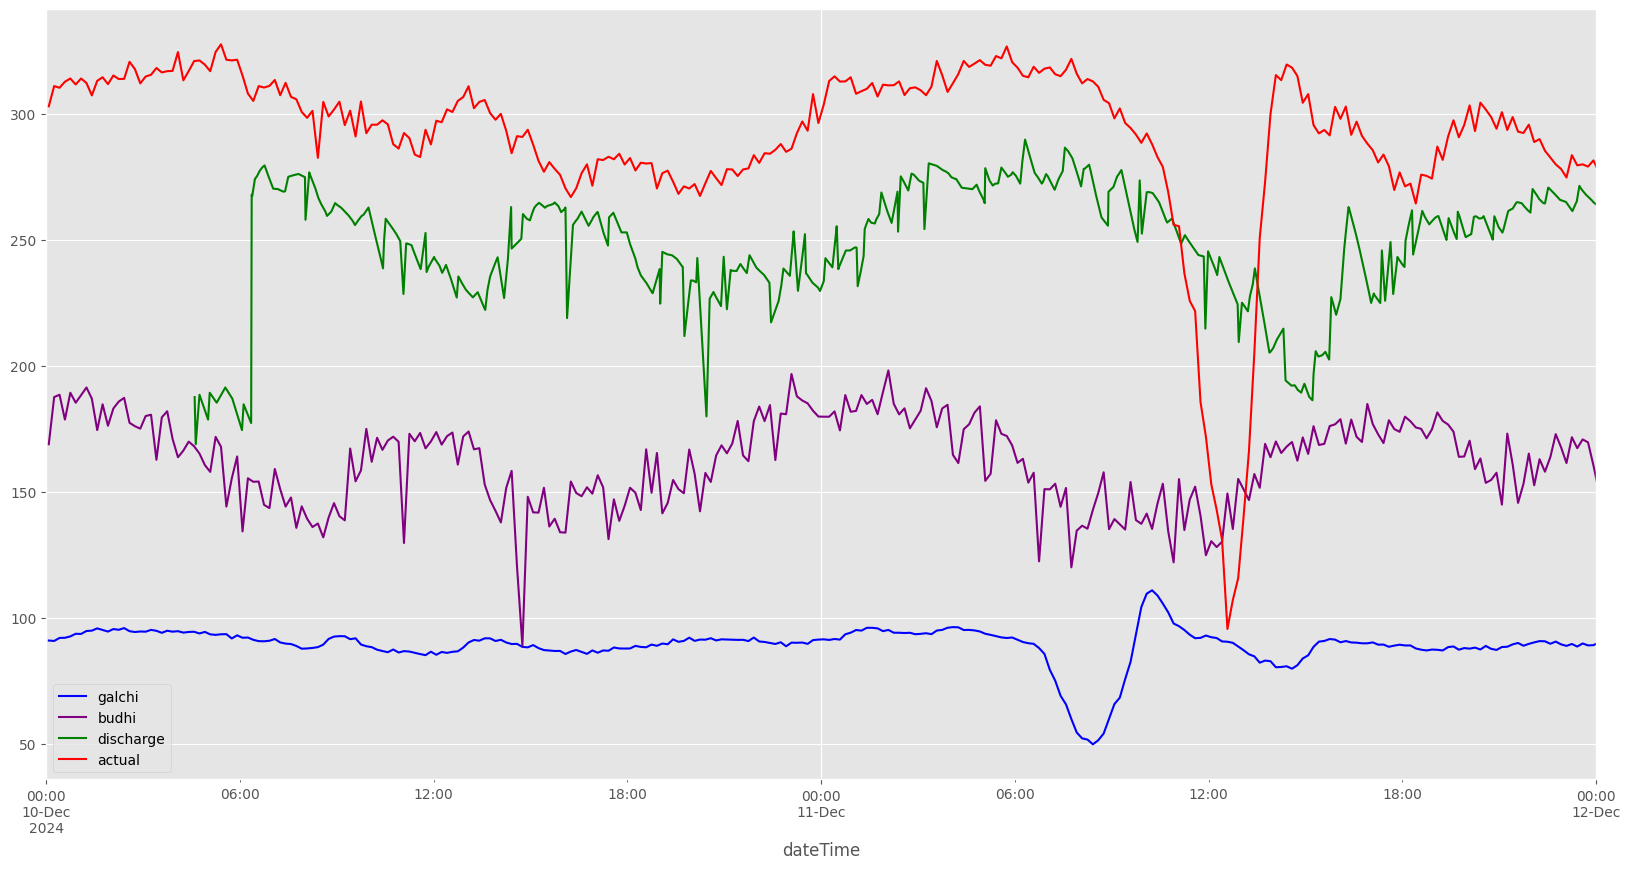

In [21]:
fig,ax=plt.subplots(figsize=(20,10),sharex=True)
galchi_df['discharge'].plot(color='blue',ax=ax,label='galchi')
budhi_df['discharge'].plot(color='purple',ax=ax,label='budhi')
computed_suirenitar_df.plot(color='green',ax=ax,label='computed')
suirenitar_df['discharge'].plot(color='red',ax=ax,label='actual')
ax.set_xlim(['2024-12-10', '2024-12-12'])
plt.legend()
plt.show()